# Identifying Fraudulent Activities

## Load Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  object        
 6   browser         151112 non-null  object        
 7   sex             151112 non-null  object        
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [4]:
data.describe().iloc[:, 1:3]

,purchase_value,age
count,151112.000000,151112.000000
mean,36.935372,33.140704
std,18.322762,8.617733
min,9.000000,18.000000
25%,22.000000,27.000000
50%,35.000000,33.000000
75%,49.000000,39.000000
max,154.000000,76.000000


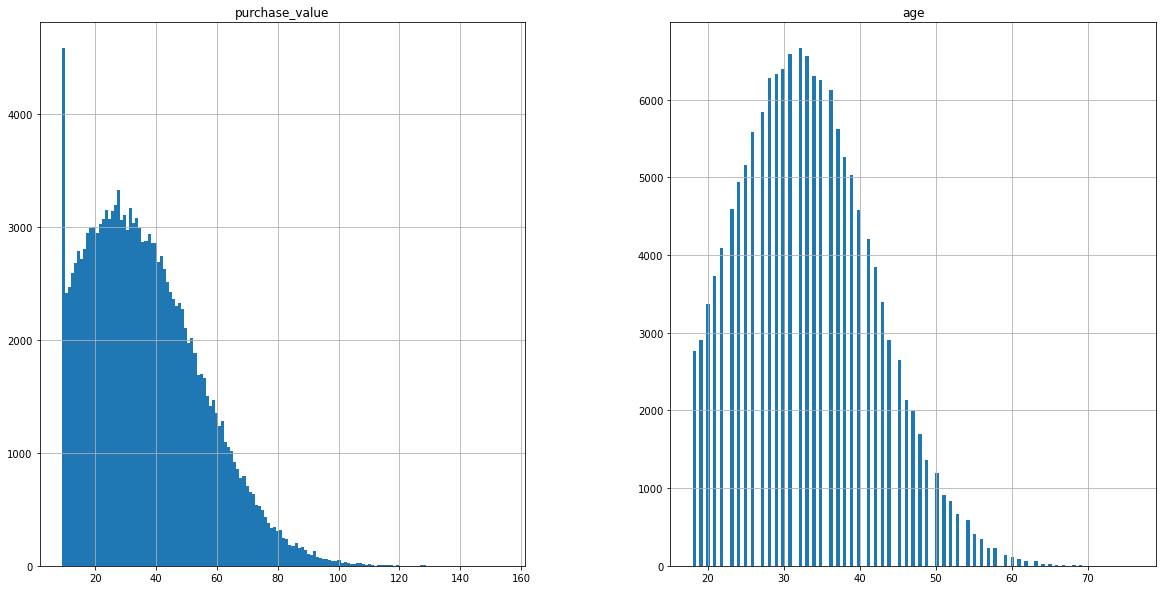

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

scale = 10
data[['purchase_value', 'age']].hist(bins='auto', figsize=(2*scale, 1*scale), layout=(1, 2))
plt.show()

In [6]:
ip_country = pd.read_csv('IpAddress_to_Country.csv')
ip_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
ip_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


## Data Preprocessing

In [8]:
def match_country_to_ip(ip=None):
    match = (ip <= ip_country['upper_bound_ip_address']) & ( ip >= ip_country['lower_bound_ip_address'])
    if match.any():
        return ip_country['country'][match].values[0]
    else:
        return 'NA'

In [9]:
data['country'] = data['ip_address'].apply(lambda x: match_country_to_ip(x))

In [10]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [11]:
data['country'].value_counts()

United States     58049
NA                21966
China             12038
Japan              7306
United Kingdom     4490
                  ...  
Myanmar               1
Vanuatu               1
Dominica              1
Niger                 1
Guadeloupe            1
Name: country, Length: 182, dtype: int64

## Feature Engineering

In [12]:
data['time_diff'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds()

device_num = data['device_id'].value_counts()
data['device_num'] = data['device_id'].map(device_num)

ip_num = data['ip_address'].value_counts()
data['ip_num'] = data['ip_address'].map(ip_num)

country_num = data['country'].value_counts()
data['country_num'] = data['country'].map(country_num)

In [13]:
features = ['purchase_value', 'source', 'browser', 'sex', 'age', 'time_diff', 'device_num', 'ip_num', 'country_num']
label = 'class'
X = data[features]
y = data[label]

In [14]:
X.head()

,purchase_value,source,browser,sex,age,time_diff,device_num,ip_num,country_num
0,34,SEO,Chrome,M,39,4506682.0,1,1,7306
1,16,Ads,Chrome,F,53,17944.0,1,1,58049
2,15,SEO,Opera,M,53,1.0,12,12,58049
3,44,SEO,Safari,M,41,492085.0,1,1,21966
4,39,Ads,Safari,M,45,4361461.0,1,1,58049


In [15]:
X['source'].value_counts()

SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64

In [16]:
X['browser'].value_counts()

Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64

In [17]:
X['sex'].value_counts()

M    88293
F    62819
Name: sex, dtype: int64

In [18]:
X_num = X.drop(['source', 'browser', 'sex'], axis=1)
X_cat = X[['source', 'browser', 'sex']]

X_cat = pd.get_dummies(X_cat)
X = pd.concat([X_num, X_cat], axis=1)

X.head()

,purchase_value,age,time_diff,device_num,ip_num,country_num,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M
0,34,39,4506682.0,1,1,7306,0,0,1,1,0,0,0,0,0,1
1,16,53,17944.0,1,1,58049,1,0,0,1,0,0,0,0,1,0
2,15,53,1.0,12,12,58049,0,0,1,0,0,0,1,0,0,1
3,44,41,492085.0,1,1,21966,0,0,1,0,0,0,0,1,0,1
4,39,45,4361461.0,1,1,58049,1,0,0,0,0,0,0,1,0,1


## Build Classifier

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
     'n_estimators': [20, 50, 100, 200, 500],
     'max_depth': [5, 10, 20, 50, 100],
     'bootstrap': [True, False],
  }

forest_clf = RandomForestClassifier(random_state=42)
forest_gs = GridSearchCV(forest_clf, param_grid, cv=5,
                         scoring='roc_auc', verbose=10,
                         n_jobs=-1)
forest_gs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 245 out of 250 | elapsed: 1

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [5, 10, 20, 50, 100],
                         'n_estimators': [20, 50, 100, 200, 500]},
             scoring='roc_auc', verbose=10)

In [21]:
forest_gs.best_score_

0.8434674163007199

In [22]:
forest_gs.best_params_

{'bootstrap': True, 'max_depth': 5, 'n_estimators': 20}

In [23]:
from sklearn.metrics import accuracy_score

forest_best = forest_gs.best_estimator_
accuracy_score(y_train, forest_best.predict(X_train))

0.9568355480261881

In [24]:
accuracy_score(y_test, forest_best.predict(X_test))

0.9560590820054

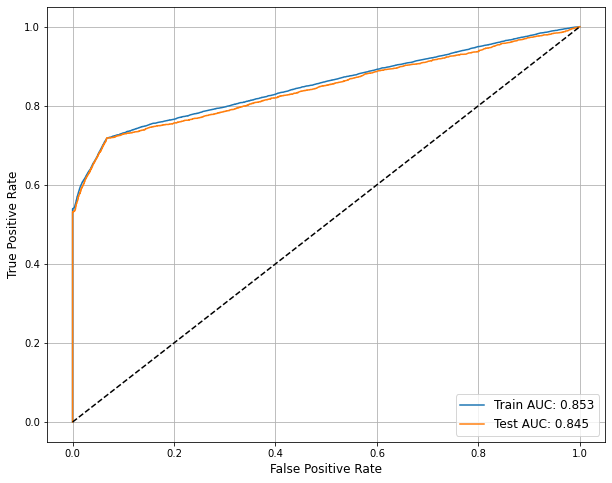

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_train_pred_score = forest_best.predict_proba(X_train)[:, 1]
y_test_pred_score = forest_best.predict_proba(X_test)[:, 1]

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred_score)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred_score)

train_auc = roc_auc_score(y_train, y_train_pred_score)
test_auc = roc_auc_score(y_test, y_test_pred_score)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(np.round(train_auc, 3)))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(np.round(test_auc, 3)))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(loc="lower right", fontsize=12)
plt.show()

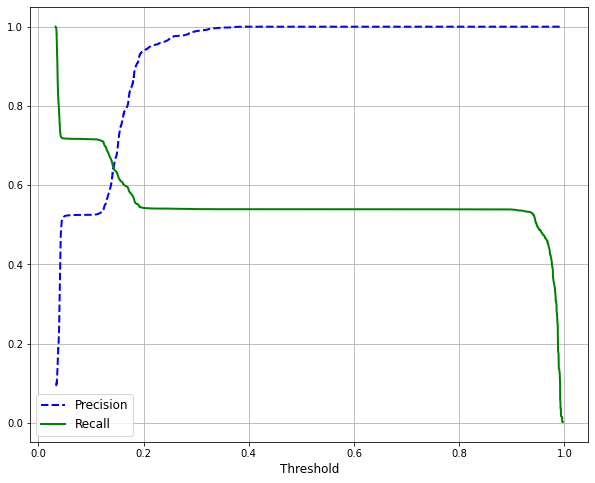

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred_score)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
ax.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=12)
ax.grid(True)
ax.legend(loc="lower left", fontsize=12)
plt.show()

In [27]:
forest_best.feature_importances_

array([3.54715611e-04, 2.83088377e-04, 5.74048142e-01, 1.80081619e-01,
       2.43634811e-01, 2.35699235e-04, 9.04279141e-05, 8.35193074e-04,
       1.33954357e-04, 7.47761749e-05, 1.08050331e-05, 1.50532353e-05,
       8.88967778e-05, 2.74035361e-05, 3.00629217e-05, 5.53512126e-05])

In [28]:
import seaborn as sns

def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    fi_df = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    plt.figure(figsize=(20, 10))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

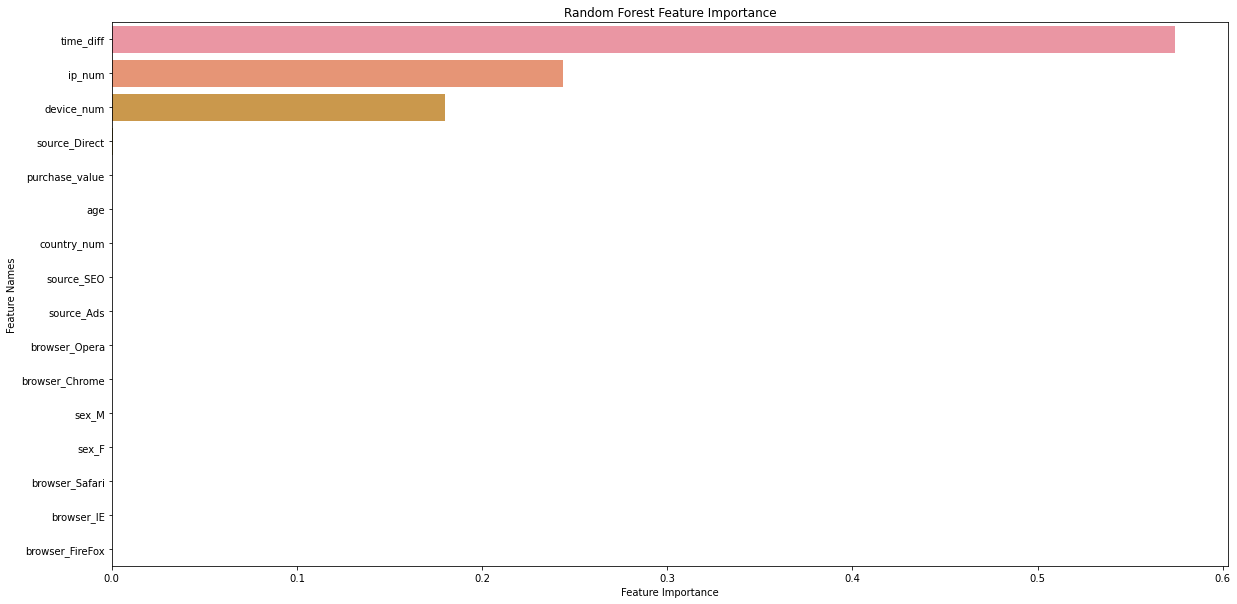

In [29]:
plot_feature_importance(forest_best.feature_importances_, X_train.columns, 'Random Forest')

### XGBosst

In [30]:
from xgboost import XGBClassifier

param_grid = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [2, 6, 12],
    "learning_rate": [0.01, 0.1, 0.3, 0.5],
    "min_child_weight": [1, 5, 15],
    "subsample":[0.5, 0.75, 1],
    "colsample_bytree":[0.5, 0.75, 1]
}

xgb = XGBClassifier(objective='binary:logistic', seed=42)
xgb_gs = GridSearchCV(xgb, param_grid, cv=5,
                      scoring='roc_auc', verbose=10,
                      n_jobs=-1)
%time xgb_gs.fit(X_train, y_train)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

CPU times: total: 2min 34s
Wall time: 2h 55min 16s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                        

In [31]:
xgb_gs.best_score_

0.8473748490683827

In [33]:
xgb_gs.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.5,
 'max_depth': 2,
 'min_child_weight': 5,
 'n_estimators': 50,
 'subsample': 0.5}

In [34]:
xgb_best = xgb_gs.best_estimator_
accuracy_score(y_train, xgb_best.predict(X_train))

0.956853194981206

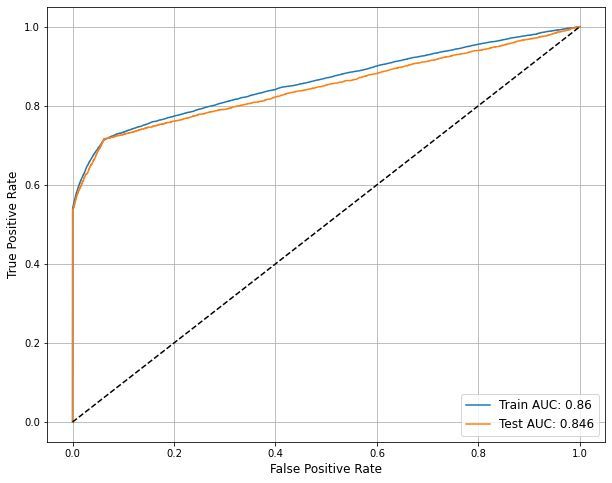

In [35]:
y_train_pred_score = xgb_best.predict_proba(X_train)[:, 1]
y_test_pred_score = xgb_best.predict_proba(X_test)[:, 1]

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred_score)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred_score)

train_auc = roc_auc_score(y_train, y_train_pred_score)
test_auc = roc_auc_score(y_test, y_test_pred_score)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(np.round(train_auc, 3)))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(np.round(test_auc, 3)))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(loc="lower right", fontsize=12)
plt.show()

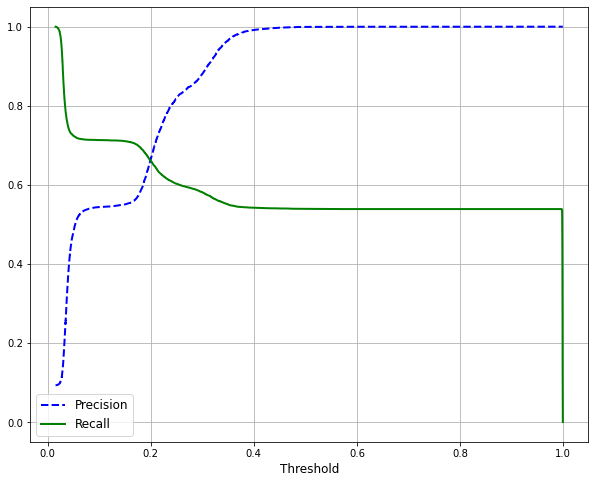

In [36]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred_score)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
ax.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=12)
ax.grid(True)
ax.legend(loc="lower left", fontsize=12)
plt.show()

In [37]:
xgb_best.feature_importances_

array([0.00458578, 0.00452012, 0.22477217, 0.26762214, 0.45640182,
       0.00460837, 0.00219072, 0.02098601, 0.00239452, 0.        ,
       0.00409068, 0.        , 0.        , 0.00388112, 0.00394652,
       0.        ], dtype=float32)

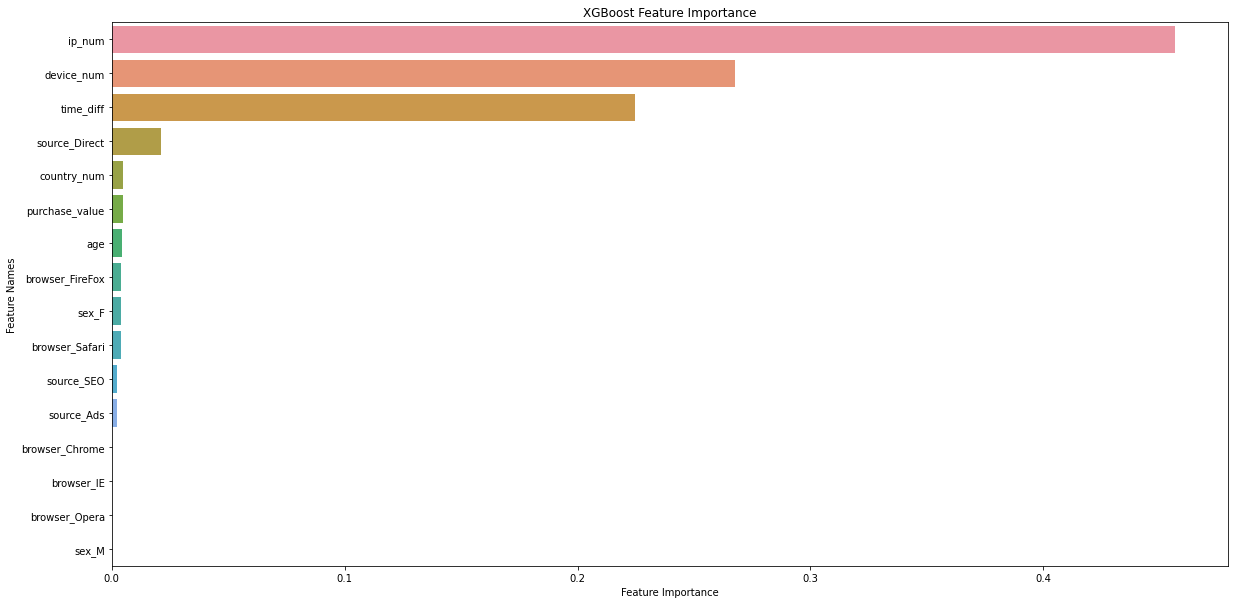

In [38]:
plot_feature_importance(xgb_best.feature_importances_, X_train.columns, 'XGBoost')